In [ ]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision
from torchvision import transforms
import torch.optim as optim
from torchvision.datasets import Flowers102
from torchvision.models import vgg16
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Install the Cleverhans library (provides adversarial attacks)
!pip install -qq git+http://github.com/tensorflow/cleverhans.git#egg=cleverhans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.6 MB/s eta 0:00:00


In [ ]:
# Import FGMS and PGD attacks
import cleverhans

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

In [ ]:
# Define the transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 128 x 128 pixels
    transforms.ToTensor(),  # Convert the images to a PyTorch tensor
])

# Download the train, test, and validation datasets
# We switched the train and test splits, since the test split was much larger than the train split
train_dataset = Flowers102(root='sample_data/flowers', split="test", transform=transform, download=True)
test_dataset = Flowers102(root='sample_data/flowers', split="train", transform=transform, download=True)
validation_dataset = Flowers102(root='sample_data/flowers', split="val", transform=transform, download=True)

100%|██████████| 344862509/344862509 [00:12<00:00, 27158800.75it/s]


Extracting sample_data/flowers/flowers-102/102flowers.tgz to sample_data/flowers/flowers-102


100%|██████████| 502/502 [00:00<00:00, 670340.85it/s]


100%|██████████| 14989/14989 [00:00<00:00, 31434211.33it/s]


In [ ]:
# Check the datasets
print(train_dataset)
print(test_dataset)
print(validation_dataset)

Dataset Flowers102
    Number of datapoints: 6149
    Root location: sample_data/flowers
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 1020
    Root location: sample_data/flowers
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 1020
    Root location: sample_data/flowers
    split=val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [ ]:
# Create dataloaders to iterate over the datasets
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=64)
validation_dataloader = DataLoader(validation_dataset, shuffle=False, batch_size=64)

In [ ]:
# Asscociate the labels and names of flowers
flower_names = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

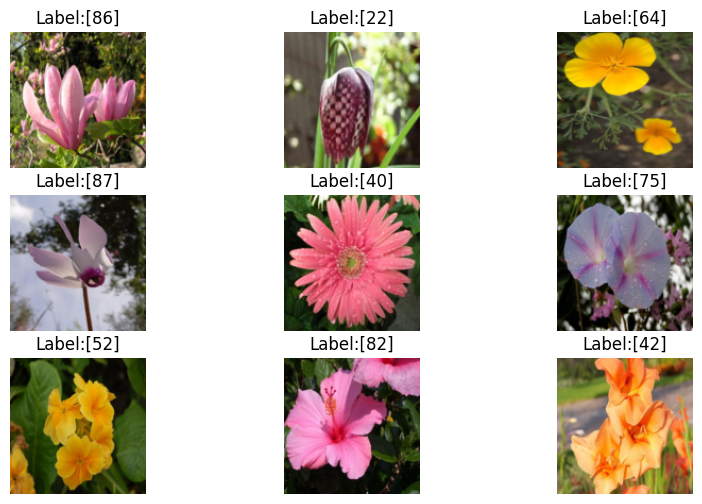

In [ ]:
# Plot several images and labels
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str([int(labels[0])]))
    plt.axis('off')

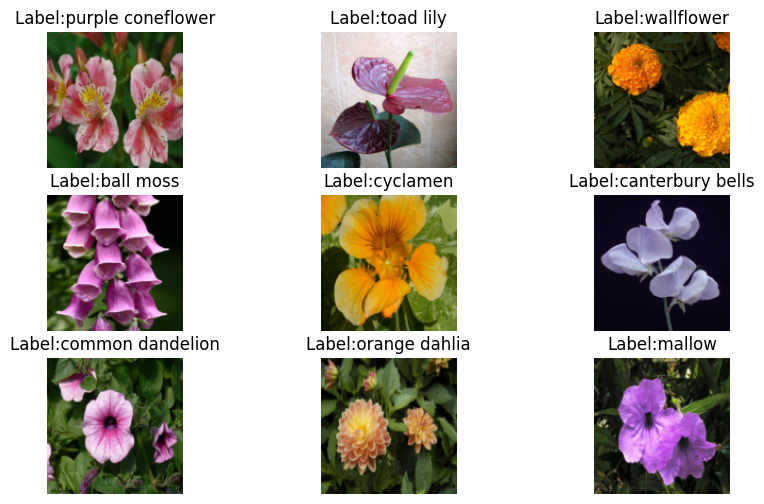

In [ ]:
# Plot several images and labels
plt.figure(figsize=(10, 6))
data = iter(train_dataloader)
for n in range(9):
    ax = plt.subplot(3, 3, n+1)
    image, labels = next(data)
    img = image[0].permute(1, 2, 0).squeeze()
    plt.imshow(img.numpy())
    plt.title('Label:' + str(flower_names.get(str(int(labels[0])), "Unknown")))
    plt.axis('off')

In [ ]:
#VGG16
VGG16 = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.3MB/s]


In [ ]:
VGG16.classifier._modules['6'] = nn.Linear(4096, 102)

In [ ]:
VGG16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:

#Training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG16.parameters(), lr=0.001, momentum=0.9)

epoch_num = 10
training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []
for epoch in range(epoch_num):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = VGG16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))

    training_loss_plot.append(running_loss)
    training_accuracy_plot.append(correct/total)

    #validation
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
      for i, data in enumerate(validation_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]

          inputs, labels = data
          labels = labels.type(torch.LongTensor)
          inputs, labels = inputs.cuda(), labels.cuda()

          # forward
          outputs = VGG16(inputs)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    val_loss_plot.append(running_loss)
    val_accuracy_plot.append(correct/total)
print('Finished Training')
print("validation ", val_accuracy_plot[epoch_num -1],"training", training_accuracy_plot[epoch_num-1])

Finished Training
validation  0.8313725490196079 training 0.9825987965522849


In [ ]:
VGG16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

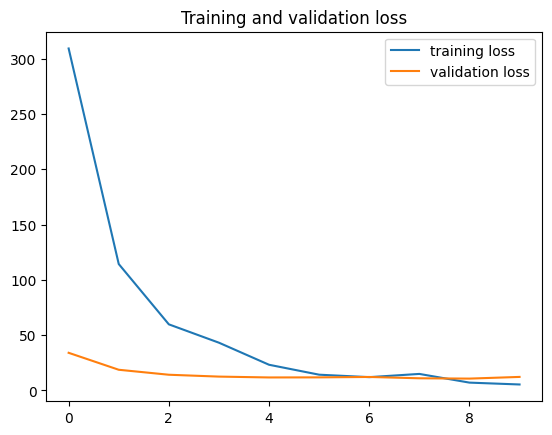

Text(0.5, 1.0, 'Training and validation accuracy')

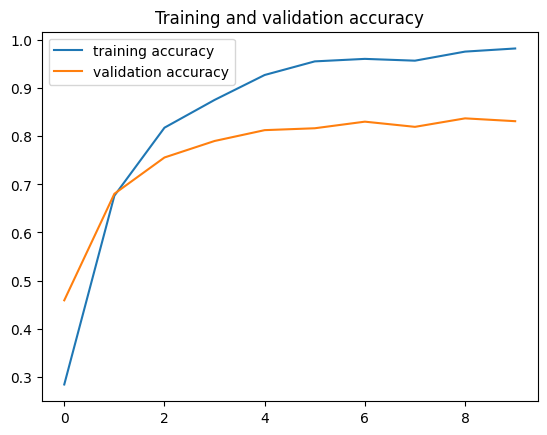

In [ ]:
#VGG16 plot
plt.plot(training_loss_plot)
plt.plot(val_loss_plot)
plt.title('Training and validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()
plt.plot(training_accuracy_plot)
plt.legend(['training loss', 'validation loss'])
plt.plot(val_accuracy_plot)
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training and validation accuracy')


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in test_dataloader:
      images, labels = data
      labels = labels.type(torch.LongTensor)
      images = images.cuda()
      labels = labels.cuda()
      outputs = VGG16(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
print('Accuracy of the network on the test images: %f %%' % (
100 * correct / total))


Accuracy of the network on the test images: 87.745098 %


In [ ]:
epsilons = [0, 1/255, 3/255, 5/255, 8/255, 20/255, 50/255, 80/255]

In [ ]:
#FSGM- VGG16
correct = 0
total = 0
accuracies_FSGM =[]
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)
for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_FSGM.append(np.mean(accuracy))
print(accuracies_FSGM)



0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.7643489583333334, 0.6604894735055885, 0.519858051625293, 0.43358518029828275, 0.37873393018992296, 0.3393018644981009, 0.3001312982490541, 0.2671276830897255]


In [ ]:
#PGD-VGG16
correct = 0
total = 0
accuracies_PGD =[]
sub_dataset = Subset(test_dataset, list(range(200)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=64)

for epsilon in epsilons:
  print(epsilon)
  accuracy = []
  for data in subsest_dataloader:
    images, labels = data
    # labels = labels.type(torch.LongTensor)
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = projected_gradient_descent(model_fn = VGG16, x =images, eps = epsilon, eps_iter =2.5*epsilon/60, nb_iter =60, norm = np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy.append(correct/total)

  accuracies_PGD.append(np.mean(accuracy))
print(accuracies_PGD)

0
0.00392156862745098
0.011764705882352941
0.0196078431372549
0.03137254901960784
0.0784313725490196
0.19607843137254902
0.3137254901960784
[0.7643489583333334, 0.5911330358085585, 0.425429622412381, 0.335919660159118, 0.2827793870761752, 0.24152225599161406, 0.20908372671956144, 0.1840779612683766]


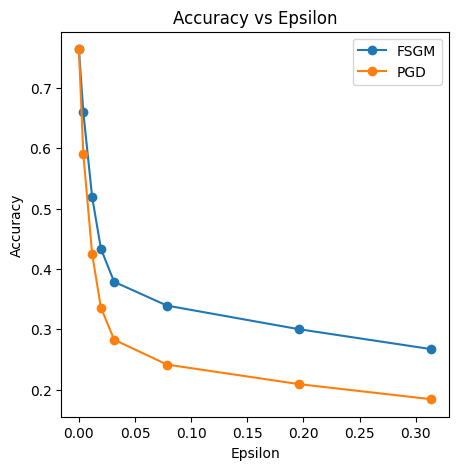

In [ ]:
#VGG16-FSGM-PGD plot
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_FSGM, "o-")
plt.plot(epsilons, accuracies_PGD, "o-")


plt.legend(['FSGM', 'PGD'])
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<ipython-input-23-a3bc2bb12e35>:13: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left, bottom, right, top, wspace, hspace)


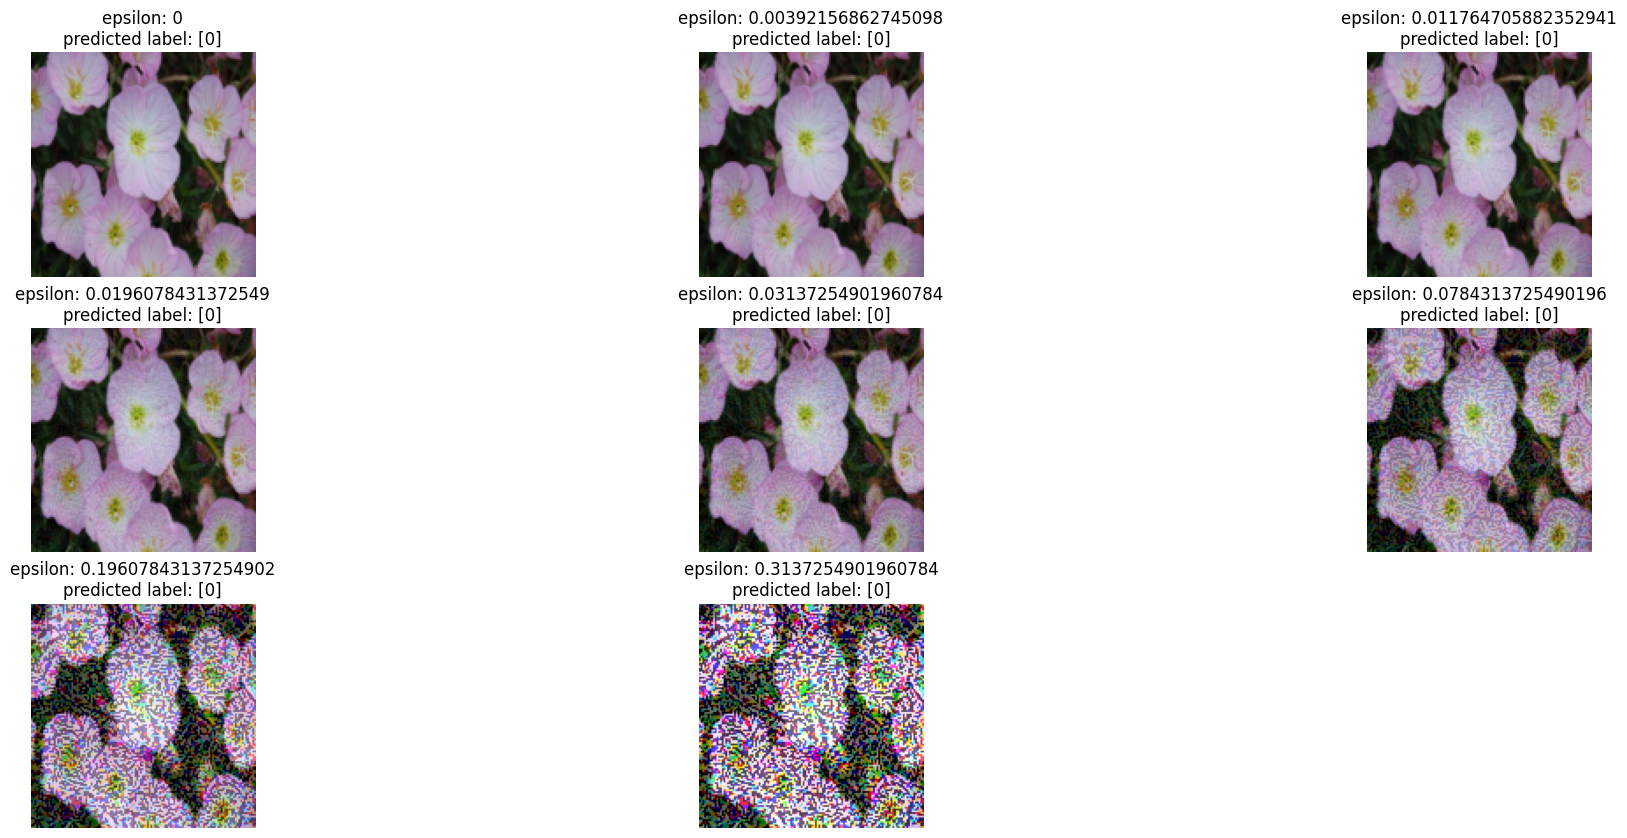

In [ ]:
#FSGM- VGG16- image plot

sub_dataset = Subset(test_dataset, list(range(100)))
subsest_dataloader = DataLoader(sub_dataset, batch_size=1)
plt.figure(figsize=(20,15), constrained_layout=True)
cnt =1
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.5   # the bottom of the subplots of the figure
top = 1.5    # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

for data in subsest_dataloader:
  for epsilon in epsilons:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    adversarial_images = fast_gradient_method(VGG16, images, epsilon, np.inf)
    outputs = VGG16(adversarial_images)
    _, predicted = torch.max(outputs.data, 1)
    plt.subplot(6, 3, cnt)
    img = adversarial_images.cpu().detach().numpy()[0]
    img = np.transpose(img, [1,2,0])
    plt.imshow(img)
    label = predicted.cpu().detach().numpy()[0]
    plt.title('epsilon: '+ str(epsilon)+ '\n' + 'predicted label: ' + str([int(labels[0])]))

    plt.axis('off')
    cnt +=1
  break

